In [1]:
# coding: utf-8
import os

import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

from mydatools.features_analyze import get_top_k_corr

% matplotlib inline

In [2]:
# pc memory is small, can't compute svd
is_in_pc = False

In [3]:
train_text_df = pd.read_csv('./data/input/training_text', sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
train_variants_df = pd.read_csv('./data/input/training_variants')
train_df = train_variants_df.merge(train_text_df, how='left', on='ID')
train_df['train_or_test'] = 'train'

test_text_df = pd.read_csv('./data/input/test_text', sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
test_variants_df = pd.read_csv('./data/input/test_variants')
test_df = test_variants_df.merge(test_text_df, how='left', on='ID')
test_df['train_or_test'] = 'test'

full_df = pd.concat([train_df, test_df])

del(train_text_df)
del(train_variants_df)
del(train_df)
del(test_text_df)
del(test_variants_df)
del(test_df)

full_df.head()

,Class,Gene,ID,Text,Variation,train_or_test
0,1.0,FAM58A,0,Cyclin-dependent kinases (CDKs) regulate a var...,Truncating Mutations,train
1,2.0,CBL,1,Abstract Background Non-small cell lung canc...,W802*,train
2,2.0,CBL,2,Abstract Background Non-small cell lung canc...,Q249E,train
3,3.0,CBL,3,Recent evidence has demonstrated that acquired...,N454D,train
4,4.0,CBL,4,Oncogenic mutations in the monomeric Casitas B...,L399V,train


In [4]:
is_train = full_df['train_or_test'] == 'train'
is_test = full_df['train_or_test'] == 'test'

In [5]:
# replace null
full_df.loc[full_df['Text'] == 'null', 'Text'] = ''

## feature

In [6]:
feature_columns = []

def add_features(features):
    if type(features) != list:
        features = [features]
    global feature_columns
    feature_columns.extend([f for f in features if f not in feature_columns])

* Text length

In [7]:
full_df['text_nb_chars'] = full_df['Text'].str.len()
full_df['text_nb_words'] = full_df['Text'].apply(lambda x: len(x.split()))
add_features(['text_nb_chars', 'text_nb_words'])

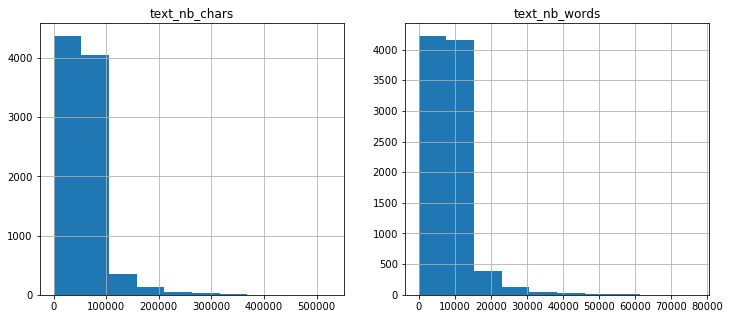

In [8]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

plt.subplot(121)
full_df['text_nb_chars'].hist()
plt.title('text_nb_chars')

plt.subplot(122)
full_df['text_nb_words'].hist()
plt.title('text_nb_words')

* text tfidf

In [9]:
def save_sparse_csr(filename,array):
    np.savez(filename,data = array.data ,indices=array.indices,
             indptr =array.indptr, shape=array.shape )

def load_sparse_csr(filename):
    loader = np.load(filename)
    return scipy.sparse.csr_matrix((  loader['data'], loader['indices'], loader['indptr']),
                         shape = loader['shape'])

In [10]:
%%time
file_path = './data/input/tmp_text_tfidf_res.npz'
if os.path.isfile(file_path):
    text_tfidf_res = load_sparse_csr(file_path)
else:
    tfidf_solver = TfidfVectorizer(stop_words='english', ngram_range=(1,1))
    tfidf_solver.fit(full_df[is_train]['Text'])
    text_tfidf_res = tfidf_solver.transform(full_df['Text'])
    save_sparse_csr(file_path, text_tfidf_res)

CPU times: user 208 ms, sys: 68 ms, total: 276 ms
Wall time: 275 ms


In [11]:
%%time

# dimensionality reduction
nb_dr_dim = 100
if not is_in_pc:
    dr_res = TruncatedSVD(nb_dr_dim).fit_transform(text_tfidf_res)
else:
    dr_res = TruncatedSVD(nb_dr_dim).fit_transform(text_tfidf_res[:, :(2*nb_dr_dim)])

1
CPU times: user 31 s, sys: 920 ms, total: 31.9 s
Wall time: 28.5 s


In [12]:
feats = ['text_word_%03d'%i for i in range(nb_dr_dim)]
for f in feats: full_df[f] = 0
full_df[feats] = dr_res
add_features(feats)

* gene/variation labelencode

In [13]:
%%time

nb_dr_dim = 100
for feat in ['Gene', 'Variation']:
    # label dummy
    encode_res = pd.get_dummies(full_df[feat]).values
    
    # dimensionality reduction
    if not is_in_pc:
        dr_res = TruncatedSVD(nb_dr_dim).fit_transform(encode_res)
    else:
        dr_res = TruncatedSVD(nb_dr_dim).fit_transform(encode_res[:, :(2*nb_dr_dim)])
        
    # add features
    feats = [feat+'_encode_%03d'%i for i in range(nb_dr_dim)]
    for f in feats: full_df[f] = 0
    full_df[feats] = dr_res
    add_features(feats)

CPU times: user 14.7 s, sys: 2.31 s, total: 17 s
Wall time: 9.35 s


## LightGBM

In [14]:
trn_df = full_df[is_train]
tst_df = full_df[is_test]

X = trn_df[feature_columns]
y = trn_df['Class'] - 1 # 1~9 to 0~8
X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

X_tst = tst_df[feature_columns]

trn_lgb = lgb.Dataset(X_trn, y_trn, free_raw_data=False)
val_lgb = lgb.Dataset(X_val, y_val, free_raw_data=False, reference=trn_lgb)

In [15]:
params = {
    'application': 'multiclass',
    'metric': 'multi_logloss',
    'num_class': 9,
    'learning_rate': 0.05,
    'seed': 0,
}
bst = lgb.train(params, trn_lgb, 1000, valid_sets=[trn_lgb, val_lgb], early_stopping_rounds=20)

[1]	training's multi_logloss: 2.07689	valid_1's multi_logloss: 2.10938
Training until validation scores don't improve for 20 rounds.
[2]	training's multi_logloss: 1.9728	valid_1's multi_logloss: 2.03133
[3]	training's multi_logloss: 1.88149	valid_1's multi_logloss: 1.96441
[4]	training's multi_logloss: 1.79932	valid_1's multi_logloss: 1.9036
[5]	training's multi_logloss: 1.72425	valid_1's multi_logloss: 1.85013
[6]	training's multi_logloss: 1.65528	valid_1's multi_logloss: 1.80112
[7]	training's multi_logloss: 1.59193	valid_1's multi_logloss: 1.75599
[8]	training's multi_logloss: 1.53321	valid_1's multi_logloss: 1.71555
[9]	training's multi_logloss: 1.47768	valid_1's multi_logloss: 1.67787
[10]	training's multi_logloss: 1.42636	valid_1's multi_logloss: 1.64339
[11]	training's multi_logloss: 1.37817	valid_1's multi_logloss: 1.61115
[12]	training's multi_logloss: 1.33273	valid_1's multi_logloss: 1.58175
[13]	training's multi_logloss: 1.28934	valid_1's multi_logloss: 1.55311
[14]	training

[113]	training's multi_logloss: 0.120859	valid_1's multi_logloss: 1.0154
Early stopping, best iteration is:
[93]	training's multi_logloss: 0.184358	valid_1's multi_logloss: 1.01088


In [16]:
# bst = lgb.train(params, trn_lgb, 1000, valid_sets=[trn_lgb, val_lgb], early_stopping_rounds=20,
#                 init_model=bst, 
#                 learning_rates=lambda iter: 0.1 * (0.99 ** iter))

In [17]:
# imp_df = pd.DataFrame([bst.feature_importance()], columns=feature_columns, index=['importance']).T.sort_values(by='importance', ascending=False)
# imp_df

## predict

In [20]:
res_df = pd.DataFrame(bst.predict(X_tst), columns=['class%d'%(i+1) for i in range(9)])
res_df['ID'] = tst_df['ID']
res_df.to_csv('./data/output/submission.csv', index=False)